Calculate the detsys errors for nue and numu. All detsys errors here are done together, as they are totally different to the nominal samples, and the varience from them calculated. This can then be added back in with the state errors in batch plot construction. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
detvar_run1_fhc = {
    "LYRayleigh": 7.59732E20, #7.60573E20, 
    "LYDown": 7.43109E20, 
    "SCE": 7.39875E20, 
    "Recomb2": 7.59105E20, 
    "WireModX": 7.64918E20, 
    "WireModYZ": 7.532E20, 
    "WireModThetaXZ": 7.64282E20,
    "WireModThetaYZ_withSigmaSplines": 7.64543E20, 
    "CV": 7.59732E20
}

intrinsic_detvar_run1_fhc = {
    "LYRayleigh_intrinsic": 2.67655E22, #2.38081E22, 
    "LYDown_intrinsic": 2.24505E22, 
    "SCE_intrinsic": 2.60685E22, #2.39023E22, 
    "Recomb2_intrinsic":  2.60657E22, #2.38193E22, 
    "WireModX_intrinsic": 2.66184E22, #2.38318E22, 
    "WireModYZ_intrinsic":  2.62256E22, #2.38416E22,
    "WireModThetaXZ_intrinsic": 2.65175E22, #2.31518E22, 
    "WireModThetaYZ_withSigmaSplines_intrinsic": 2.62256E22, #2.31421E22, 
    "CV_intrinsic": 2.68294E22 #2.37261E22   
}

In [3]:
standard_dict = detvar_run1_fhc
intrinsic_dict = intrinsic_detvar_run1_fhc

run = 'run1'
detvar = detvar_run1_fhc

In [4]:
variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v",
        #"theta", # angle between incoming and outgoing leptons in radians
        "weightSplineTimesTune", "nu_e", "true_pt","true_pt_visible","true_p",
        "true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y",
        "true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z",
        "ppfx_cv"
    ]

In [5]:
input_path = "/media/alex/TOSHIBA EXT/detSys/"

In [6]:
detvar.keys()

dict_keys(['LYRayleigh', 'LYDown', 'SCE', 'Recomb2', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ_withSigmaSplines', 'CV'])

In [7]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

In [8]:
beamon_pot = 2e+20

In [9]:
xvar = "reco_e"
bins = np.arange(0, 5.5, 0.5)
#xvar = "reco_nu_vtx_sce_x"
#bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

xlow = bins[0]
xhigh = bins[-1]

x_label = "Reconstructed Energy [GeV]"
#x_label = "Reconstructed X Position [cm]"

In [10]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUMU_SEL_QUERY += ' and nu_e > 0.04 and nu_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [11]:
detvar_dict = {}

In [12]:
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

In [13]:
import pandas as pandas

for variation in detvar.keys(): 
        
    print("Plotting", variation)
    
    standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run+"_overlay_"+variation+".root"
    intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run+"_overlay_"+variation+"_intrinsic.root"
    
    f_standard = uproot.open(standard_input_file)[fold][tree]
    f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]
    
    uproot_v = [f_standard, f_intrinsic]
    
    df_standard = f_standard.pandas.df(variables, flatten=False)
    df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)
    
    print("All good to here.")
    
    INTERCEPT = 0.0
    SLOPE = 0.83

            
    
    for i, df in enumerate([df_standard, df_intrinsic]):
            
        up = uproot_v[i]
        load_data_run123.process_uproot_numu(up, df)
        trk_llr_pid_v = up.array('trk_llr_pid_score_v')
        trk_id = up.array('trk_id')-1 
        trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
        df['trkpid'] = trk_llr_pid_v_sel
        df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
        df["extdata"] = np.zeros_like(df["isVtxInFiducial"])
        #df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
        #df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
        
        #df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000

        df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
        df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
        df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
        df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
            
        # bool for is signal vs is not signal 
        df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==2)
                             & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
    
            
        print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))
        
    # APPLY SW TRIGGER
    df_standard = df_standard.query('nslice==1')
    df_intrinsic = df_intrinsic.query('nslice==1')
    
    # POT SCALING
    df_standard['pot_scale'] = beamon_pot/standard_dict.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
    df_standard['pot_scale_dirt'] = (beamon_pot/standard_dict.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
    df_intrinsic['pot_scale'] = beamon_pot/intrinsic_dict.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 
    
    # remove nue CC events 
    print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
    len1 = len(df_standard)

    idx = df_standard.query(nueCC_query).index
    df_standard.drop(idx, inplace=True)
    len2 = len(df_standard) 

    print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above
    
    df_standard_sel = df_standard.query(NUMU_SEL_QUERY).copy()
    df_intrinsic_sel = df_intrinsic.query(NUMU_SEL_QUERY).copy()

    standard_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale'])[0]
    plt.close()
    
    print("non-nueCC events = ", sum(standard_counts))
    
    dirt_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale_dirt'])[0]
    plt.close()
    
    print("dirt events = ", sum(dirt_counts))
    
    intrinsic_counts = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]
    plt.close()

    
    print("nue CC events = ", sum(intrinsic_counts))

    
    # store counts in a dictionary 
    detvar_dict[variation] = list(standard_counts)
    detvar_dict[variation+'_intrinsic'] = list(intrinsic_counts)
    detvar_dict[variation+'_dirt'] = list(dirt_counts)

Plotting LYRayleigh
All good to here.
trk_llr_pid_v  [[] [] [] ... [] [0.96771365 -0.05971109] []]
trk_score_v  [[] [] [] ... [] [0.999961 0.757183] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [0.44036505 0.075542904] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [1.1579986 14.999432] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


is_signal check: True
trk_llr_pid_v  [[0.8791839 -0.5668867 0.75340277 0.051947165 0.55477494 0.05438109] [0.9178614 -0.657705 -0.3507073 0.079191916 -0.17838034] [0.7518365 -0.40248334 0.50615317] ... [0.5034287] [0.9048322 0.15703626 0.0372189] [0.9614419 -0.101456165 -0.21476477]]
trk_score_v  [[0.006814585 0.9320525 0.08157959 0.78500074 0.007837373 0.72250056] [0.0051906235 0.8714738 0.8165461 0.94197124 0.97195673] [0.013615373 0.89416176 0.7423128] ... [0.027091699] [0.0034941405 0.75312394 0.9482997] [0.05735997 0.27799028 0.78699076]]
Here:
trk_range_muon_mom_v  [[0.32113224 0.1983176 0.15863928 0.072748065 0.19880025 0.048824213] [0.28709587 0.13333708 0.10779776 0.077060916 0.06478604] [0.15416187 0.16079958 0.15353757] ... [0.2341574] [0.2546741 0.105985686 0.049958996] [0.48895058 0.11006524 0.08938548]]
trk_mcs_muon_mom_v  [[0.27599993 0.4149982 0.24700032 14.999432 0.10900004 -1.0] [0.1860002 0.40399835 0.19700022 14.999432 14.999432] [0.10400003 0.9059919 0.5569964] ...

/tmp/ipykernel_37938/3834041273.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intrinsic['pot_scale'] = beamon_pot/intrinsic_dict.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic')


# nueCC in AV in standard overlay det. sys. sample = 3045
# of nueCC in AV removed = 3045
non-nueCC events =  1815.0469961772255
dirt events =  1361.2852471329145
nue CC events =  21.794057595099865
Plotting LYDown
All good to here.
trk_llr_pid_v  [[0.98124784] [] [0.93819624 0.7752653 -0.027052782 0.055031985] ... [] [] [0.8493995]]
trk_score_v  [[0.99999946] [] [0.977496 0.87158513 0.7900027 0.7379162] ... [] [] [0.01264332]]
Here:
trk_range_muon_mom_v  [[0.65463156] [] [0.35023868 0.18487811 0.077490196 0.06247144] ... [] [] [0.21946357]]
trk_mcs_muon_mom_v  [[1.169003] [] [0.79399514 0.21500026 14.999432 14.999432] ... [] [] [0.106000036]]
is_signal check: True
trk_llr_pid_v  [[0.81432956 -0.82517934 0.16484225] [0.9038493 0.8596653 0.014079793 -3.4028235e+38] [0.9175486 0.11147104] ... [] [] [0.8296641 0.7532229 0.81869847 -0.5168657 -0.49478522]]
trk_score_v  [[0.6984235 0.9824812 0.79359025] [0.006375608 0.004945949 0.6334297 -1.0] [0.9951428 0.9526803] ... [] [] [0.9187424 0.04

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


is_signal check: True
trk_llr_pid_v  [[0.9439124] [0.97995174 -0.0047236416 0.20969991] [0.93416715 -0.63571125] ... [0.6189849] [0.85808563 0.15240024 0.11584848 0.10822115 0.08434532 0.06776571] []]
trk_score_v  [[0.0091460515] [0.9999998 0.35450473 0.040331535] [0.027245315 0.9422009] ... [0.6094864] [0.015888622 0.44456366 0.9747938 0.9684188 0.9194986 0.81532407] []]
Here:
trk_range_muon_mom_v  [[0.42608783] [0.6463875 0.090667106 0.100970246] [0.32007232 0.1299498] ... [0.12832928] [0.19582948 0.08944978 0.06364471 0.057526 0.055797726 0.049936257] []]
trk_mcs_muon_mom_v  [[0.35299873] [0.68899775 0.26600012 0.5429966] [0.2630001 0.42499807] ... [0.17700018] [0.10300003 14.998431 14.998431 14.998431 14.99443 14.99643] []]
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3127
# of nueCC in AV removed = 3127
non-nueCC events =  1825.992085035054
dirt events =  1369.494063776292
nue CC events =  21.730963140711772
Plotting WireModX
All good to here.
trk_llr

In [14]:
## CV background event rate 
x1 = plt.hist(df_standard_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel.query('is_signal==False')['ppfx_cv']*df_standard_sel.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel.query('is_signal==False')['pot_scale'])[0]

plt.close()

x3 = plt.hist(df_standard_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel.query('is_signal==False')['ppfx_cv']*df_standard_sel.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel.query('is_signal==False')['pot_scale_dirt'])[0]

plt.close()

#x2 = plt.hist(df_intrinsic_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
#            weights=df_intrinsic_sel.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel.query('is_signal==False')['pot_scale'])[0]
x2 = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]

plt.close()

In [15]:
detvar_dict['cv_total_bkgd'] = x1+x2+x3

print(x2)

[1.34668422 5.09947926 5.370778   3.91204492 2.53589533 1.58443992
 1.2218609  0.50510195 0.27211546 0.17834228]


In [16]:
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]
bin_centers = []
for a in range(len(bins)-1): 
    bin_centers.append(round(bins[a] + (bins[a+1]-bins[a])/2, 3))

In [17]:
#background should correspond to the dirt?

detvar_dict['cv_total_bkgd']

array([120.93182945, 470.80089594, 461.87384603, 266.76659282,
       139.42463983,  53.03520989,  32.42194957,  17.75299236,
        10.70691704,   2.66668992])

[1.34668422 5.09947926 5.370778   3.91204492 2.53589533 1.58443992
 1.2218609  0.50510195 0.27211546 0.17834228]


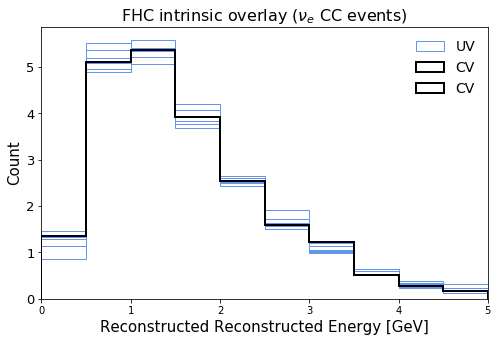

In [18]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV_intrinsic': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV_intrinsic'], color='black', label='CV', linewidth=2)

current = (plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV_intrinsic'], color='black', label='CV', linewidth=2)[0])

print(current)

plt.title('FHC intrinsic overlay ($\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Count' , fontsize=15) # 2.68294E22
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

[288.57820675 746.55822876 431.19064168 189.7702051   88.64255968
  31.07405311  18.79762085  10.39851096   6.27262267   1.42191294]


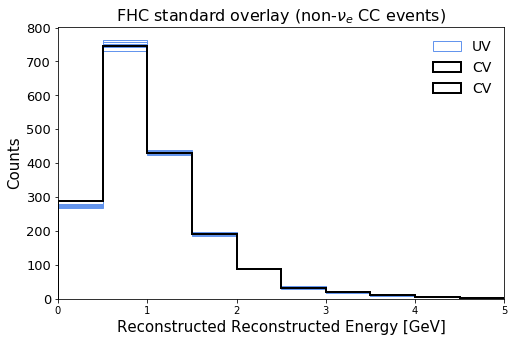

In [19]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV'], color='black', label='CV', linewidth=2)

current = plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV'], color='black', label='CV', linewidth=2)

print(current[0])


plt.title('FHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_standard.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

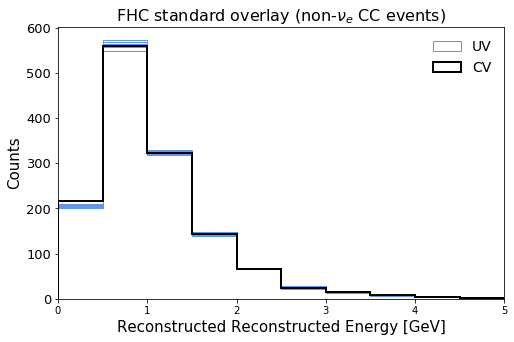

In [20]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV_dirt'], color='black', label='CV', linewidth=2)


plt.title('FHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_standard.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

In [21]:
detvar_dict['CV']

[288.5782067490949,
 746.5582287604003,
 431.19064167825013,
 189.77020510387024,
 88.64255968010411,
 31.07405310511399,
 18.79762085433572,
 10.398510958118095,
 6.272622672741591,
 1.421912935096998]

In [49]:
def calcCov(var, bins, ncv_nu, ncv_total, uni_counts, plot=False, save=False, axis_label=None, pot=None, isrun3=False, xticks=None, xhigh=None): 
    
    # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
    # ncv total is the total event rate -- (MC + EXT or estimated signal)
    # when background subtracting these two are the same  
    
    # compute the cov matrix 
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    N = len(uni_counts)
    print('number of universes = ', N)
    

    #####################################################
    
    for k in range(N): 
        
        uni = uni_counts[k]
        #print("uni = ", uni)

        for i in range(len(bins)-1): 

            cvi = ncv_nu[i]
            uvi = uni[i]
            #print("uvi = ", uvi)


            for j in range(len(bins)-1): 
                
                cvj = ncv_nu[j]
                uvj = uni[j]
        
                c = ((uvi - cvi)*(uvj - cvj)) / N

                cov[i][j] += c
                
                #print("ncv_total[i]*ncv_total[j] ", ncv_total[i]*ncv_total[j])
                #print(ncv_total[i])
                if ncv_total[i]*ncv_total[j] != 0: 
                    frac_cov[i][j] += c/(ncv_total[i]*ncv_total[j])
                    #frac_cov[i][j] = c/(ncv_total[i]*ncv_total[j])
            
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, cov, cmap='OrRd', edgecolors='k')
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)

        plt.title('Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_cov.pdf", transparent=True, bbox_inches='tight') 
            print('saving to: '+save)
        plt.show()
        
        ##################################
        # fractional covariance 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, frac_cov, cmap='OrRd', edgecolors='k')#, vmin=0, vmax=.03)
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        plt.title('Fractional Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_frac_cov.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################    
    # compute the corr matrix 

    for i in range(len(cov)): 
        for j in range(len(cov[i])): 
            
            #print(i, j, cov[i][j], cov[i][i], cov[j][j])

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
            #print(cor[i][j])
    
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))

        plt.pcolor(bins, bins, cor, cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
    

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])
            
        plt.title('Correlation Matrix', fontsize=16)
        if save: 
            plt.savefig(save+var+"_cor.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################
    
    # sys_err = [np.sqrt(x) for x in np.diagonal(cov)]
    # percent error = [y/z for y,z in zip(sys_err, ncv)] # w.r.t. to whatever event rate is being used (total or background subtracted)
        
    dictionary = {
        'cov' : cov, 
        'frac_cov' : frac_cov, 
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    }
           
    return dictionary

In [50]:
detvar_dict['CV_dirt']

[216.43365506182087,
 559.9186715702981,
 323.39298125868527,
 142.32765382790512,
 66.48191976007456,
 23.305539828836345,
 14.098215640750595,
 7.798883218589026,
 4.7044670045563635,
 1.0664347013228053]

In [52]:
# need to CV background subtract before computing the covariance

detsys_cov_fhc = {}

#print(type(detvar_dict['CV']))
#print(detvar_dict['CV'])

for variation in detvar_run1_fhc.keys(): 
    
    print(variation)
    
    if variation=='CV': 
        continue
        
        
    # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
    # ncv total is the total event rate -- (MC + EXT or estimated signal)
    # when background subtracting these two are the same
    # so can just add in dirt with the others
    
    #Background subtracting reduces the values to zero
    detsys_cov_fhc[variation] = calcCov(xvar, bins, 
                                        [(a+b+d) for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                        [(a+b+d) for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                        [ [(a+b+d) for a,b,c,d in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'], detvar_dict[variation+"_dirt"])] ] )
    

    #detsys_cov_fhc[variation] = calcCov(xvar, bins, 
    #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
    #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
    #                                    [ [(a+b) for a,b,c in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'])] ] )
    

LYRayleigh
number of universes =  1
LYDown
number of universes =  1
SCE
number of universes =  1
Recomb2
number of universes =  1
WireModX
number of universes =  1
WireModYZ
number of universes =  1
WireModThetaXZ
number of universes =  1
WireModThetaYZ_withSigmaSplines
number of universes =  1
CV


In [42]:
cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
            
        cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
        frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
        
# compute the corr matrix 
for i in range(len(cov)): 
    for j in range(len(cov[i])): 

        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
            cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
    'cor' : cor
} 

<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_5735/2880698531.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
/tmp/ipykernel_5735/2880698531.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])


In [43]:
detsys_dict['fractional_uncertainty']

array([0.12496892, 0.03436485, 0.0302339 , 0.06025606, 0.06895463,
       0.38018678, 0.36042351, 0.31675118, 0.39734224, 1.55058441])

In [44]:
np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_frac_07Jul.csv", 
           detsys_dict['fractional_uncertainty'],
           delimiter =", ", 
           fmt ='% s')

In [44]:
detsys_dict['cov']

[[4004.2419194105223,
  -1257.9937789301243,
  -219.4292495846282,
  -547.8075164718333,
  -487.5672775577117,
  -1280.785507284765,
  283.59076341231076,
  -10.355563706715188,
  236.49539653352477,
  -229.94017875937806],
 [-1257.9937789301243,
  2031.4965305883754,
  -249.3529626436124,
  530.6521972524725,
  237.36155353079278,
  411.2974227405561,
  -59.27955126249341,
  114.67204143863918,
  -120.11027468806944,
  55.256724146196696],
 [-219.4292495846282,
  -249.3529626436124,
  527.9141960610766,
  -98.4846633102687,
  142.5579801728154,
  107.07829691992092,
  -65.75375919863656,
  15.128928625629726,
  -31.167124510258237,
  23.315991234307383],
 [-547.8075164718333,
  530.6521972524725,
  -98.4846633102687,
  409.9261442349644,
  71.00055230729538,
  173.47577624052562,
  75.67138966242575,
  -55.01342556416563,
  -35.30453029124387,
  34.55770390945934],
 [-487.5672775577117,
  237.36155353079278,
  142.5579801728154,
  71.00055230729538,
  118.18762632796731,
  168.3277939

In [45]:
detsys_err_std = np.sqrt( np.diag((detsys_dict['cov'])))
print(detsys_err_std)
print("")

detsys_err = ( np.diag((detsys_dict['cov'])))
print(detsys_err)

[63.27907963 45.07212587 22.97638344 20.24663291 10.87141326 21.27678549
 12.29682027  5.92403774  4.46978439  4.1349278 ]

[4004.24191941 2031.49653059  527.91419606  409.92614423  118.18762633
  452.70160085  151.21178875   35.09422317   19.97897247   17.09762791]


In [35]:
np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_07Jul.csv", 
           detsys_err,
           delimiter =", ", 
           fmt ='% s')

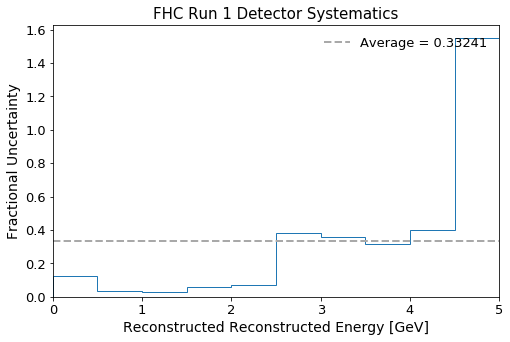

In [46]:
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

plt.figure(figsize=(8, 5))

#cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
#cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

plt.hist(bin_centers, bins, weights=detsys_dict['fractional_uncertainty'], histtype='step')

plt.hlines(np.average(detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(detsys_dict['fractional_uncertainty']), 5)))

plt.xlim(xlow, xhigh)
#plt.xlim(0, 5)
#plt.ylim(0, 1)

plt.legend(fontsize=13,  frameon=False)

plt.xlabel("Reconstructed "+x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 Detector Systematics", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [1]:
##################################################

### Try to recreate detsys study now

Intrinsic

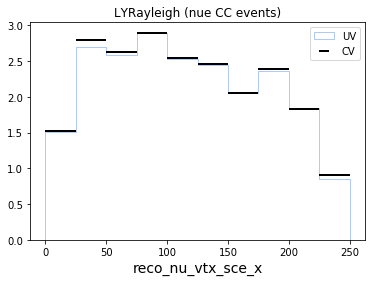

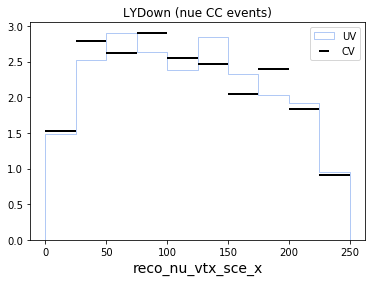

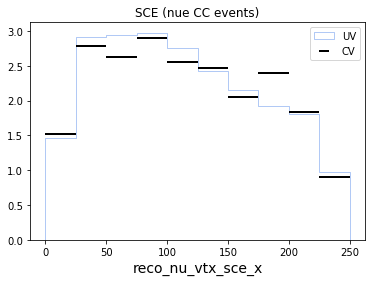

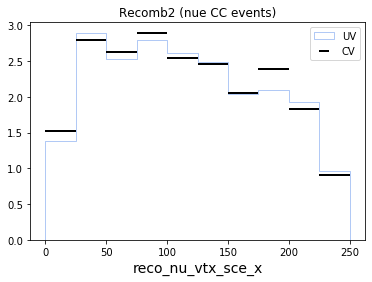

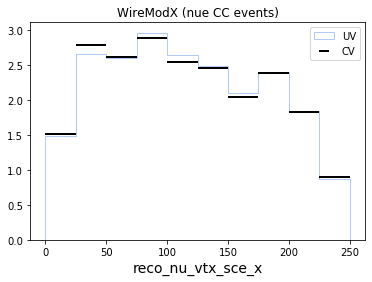

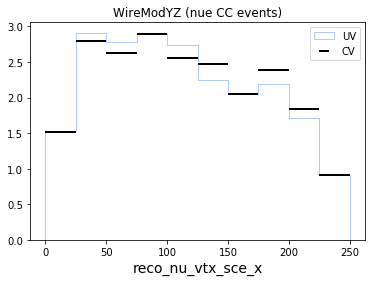

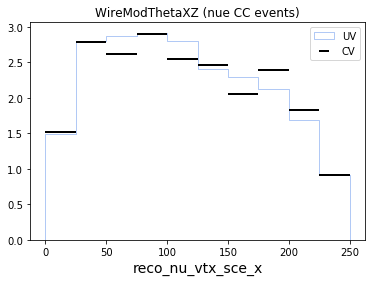

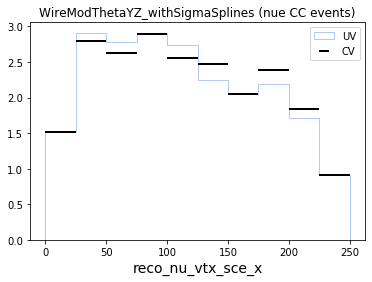

In [65]:
for variation in detvar: 
    
    if variation=='CV': 
        continue
    
    plt.hist(bin_centers, bins, histtype='step', 
                        range=[bins[0], bins[-1]], weights=detvar_dict[variation+'_intrinsic'], 
                        color='cornflowerblue', linewidth=0.5, label='UV')
    
    plt.errorbar(bin_centers, detvar_dict['CV_intrinsic'], xerr=x_err, fmt='none', color='black', linewidth=2, label='CV')
    plt.xlabel(xvar, fontsize=14)
    #plt.ylabel('$\\nu$ / '+str(beamon_pot)+' POT', fontsize=14)
    plt.title(variation+' (nue CC events)')
    plt.legend()
    plt.show()

In [66]:
detsys_cov_nueCC = {}


for variation in detvar.keys(): 
    
    if variation=='CV': 
        continue
   
    detsys_cov_nueCC[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict['CV_intrinsic'], 
                                              detvar_dict['CV_intrinsic'], 
                                              [detvar_dict[variation+'_intrinsic']])
  

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [67]:
# TOTAL cov, corr, fractional uncertainty -- nue CC 


cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
            frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])

for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
nueCC_detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

nueCC_detsys_dict['fractional_uncertainty']

<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_5213/1594932613.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_5213/1594932613.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])


array([0.10971793, 0.13999577, 0.21006554, 0.1033928 , 0.18070073,
       0.20011517, 0.18830069, 0.32061546, 0.14343985, 0.13160984])

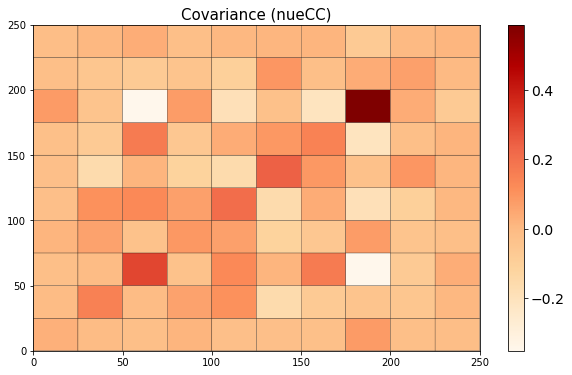

In [68]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict['cov'], cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('Covariance (nueCC)', fontsize=15)

plt.show()

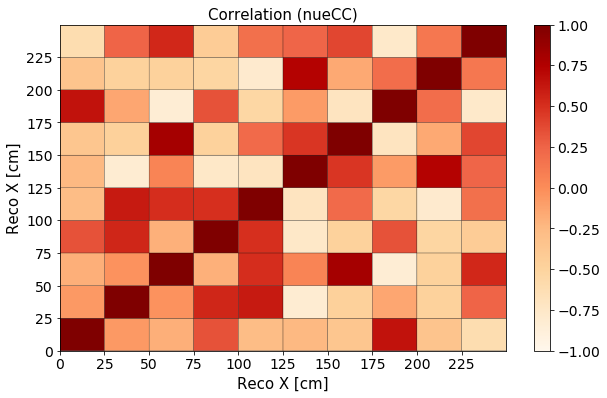

In [69]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(bins[:-1], fontsize=14)
plt.yticks(bins[:-1], fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Correlation (nueCC)', fontsize=15)

plt.show()

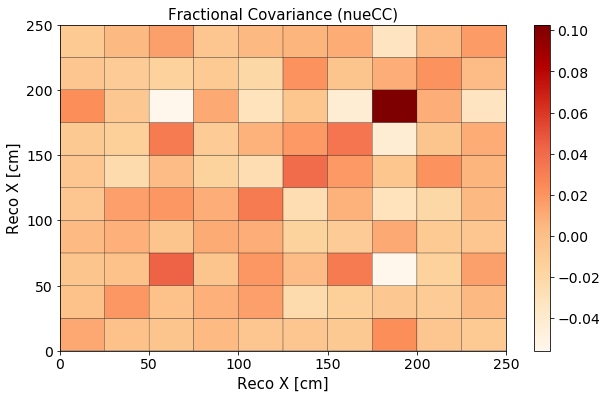

In [70]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Fractional Covariance (nueCC)', fontsize=15)

plt.show()

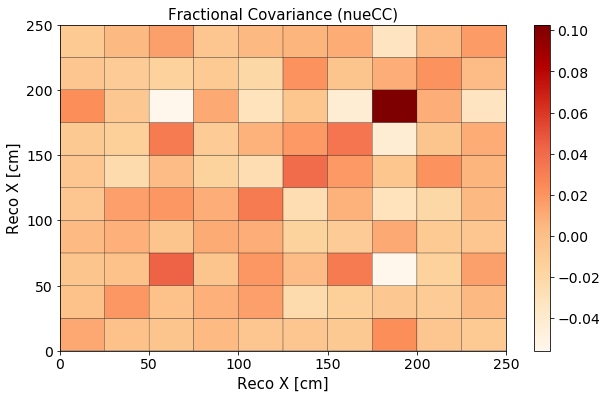

In [71]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Fractional Covariance (nueCC)', fontsize=15)

plt.show()

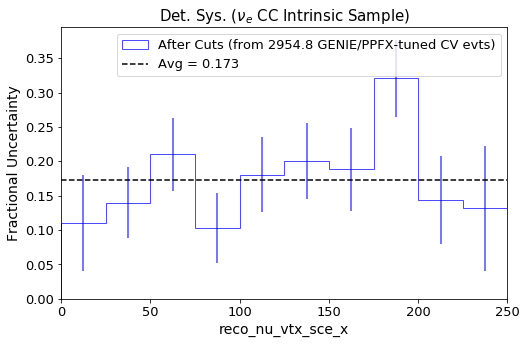

In [72]:

x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]



cv_cut = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune'])[0]
plt.close()

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]

plt.figure(figsize=(8, 5))

plt.errorbar(bin_centers, nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
             yerr=cv_cut_err, 
             color='blue', alpha=0.7)

plt.hist(bin_centers, bins, weights=nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
         label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

plt.hlines(np.average(nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
           label='Avg = '+str(round(np.average(nueCC_detsys_dict['fractional_uncertainty']), 3)))

plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(xvar, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("Det. Sys. ($\\nu_{e}$ CC Intrinsic Sample)", fontsize=15)
#plt.savefig(parameters(ISRUN3)['plots_path']+"RHCRUN3DetSys.pdf", transparent=True, bbox_inches='tight') 

plt.show()

In [73]:
evolution_dict = {}

In [74]:
evolution_dict['nueCC_bdtcut'] = nueCC_detsys_dict['fractional_uncertainty']
evolution_dict['nueCC_bdtcut_evts'] = round(sum(cv_cut),2)
evolution_dict['nueCC_bdtcut_err'] = cv_cut_err

Standard

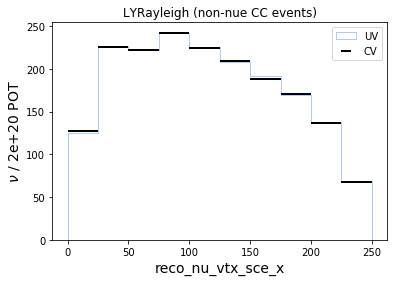

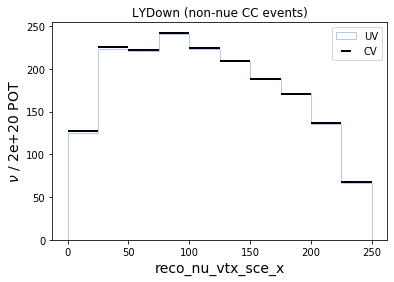

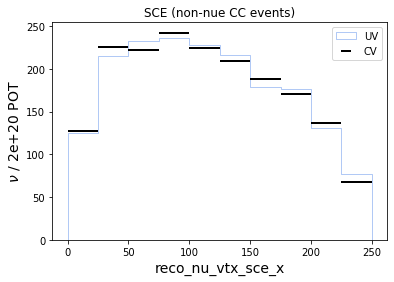

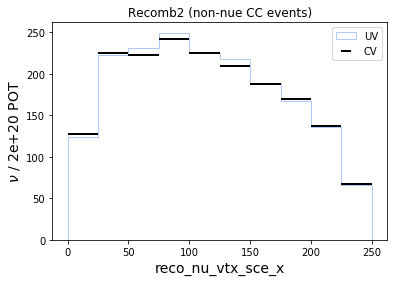

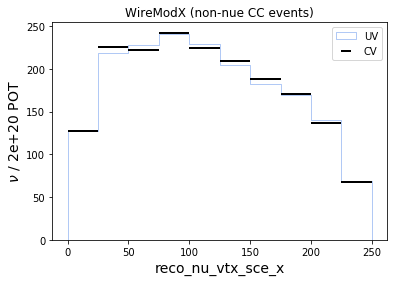

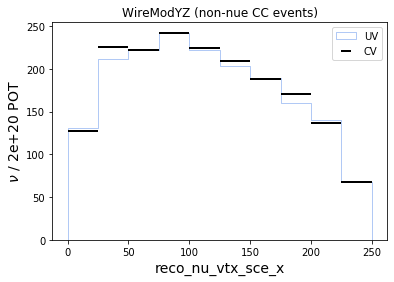

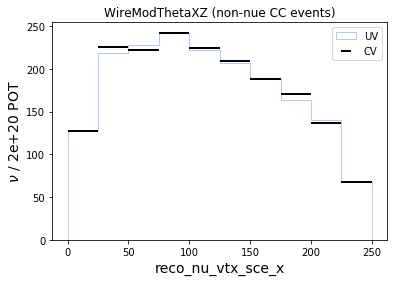

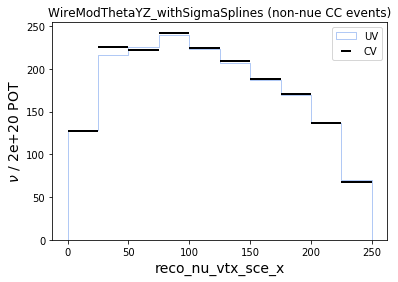

In [75]:
for variation in detvar: 
    
    if variation=='CV': 
        continue
    
    plt.hist(bin_centers, bins, histtype='step', 
                        range=[bins[0], bins[-1]], weights=detvar_dict[variation], 
                        color='cornflowerblue', linewidth=0.5, label='UV')
    
    plt.errorbar(bin_centers, detvar_dict['CV'], 
                 xerr=x_err, fmt='none', color='black', linewidth=2, label='CV')
    plt.xlabel(xvar, fontsize=14)
    plt.ylabel('$\\nu$ / '+str(beamon_pot)+' POT', fontsize=14)
    plt.title(variation+' (non-nue CC events)')
    plt.legend()
    plt.show()

In [76]:
detsys_cov_non_nueCC = {}


for variation in detvar.keys(): 
    
    if variation=='CV': 
        continue
    
    # calc covariance for each unisim - fractional uncertainty WRT nonnueCC 
    detsys_cov_non_nueCC[variation] = calcCov(xvar, bins, detvar_dict['CV'], 
                                              detvar_dict['CV'], 
                                              [detvar_dict[variation]])
   

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [77]:
#  cov, corr, fractional uncertainty -- non nue CC

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov_non_nueCC[x]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
            frac_cov[i][j] = sum([detsys_cov_non_nueCC[x]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])

for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
non_nueCC_detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_5213/2453006372.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_non_nueCC[x]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_5213/2453006372.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_non_nueCC[x]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])


In [78]:
non_nueCC_detsys_dict['fractional_uncertainty']

array([0.05140602, 0.09801746, 0.07692768, 0.04191414, 0.03133209,
       0.06709953, 0.06144462, 0.08203954, 0.06169271, 0.15950864])

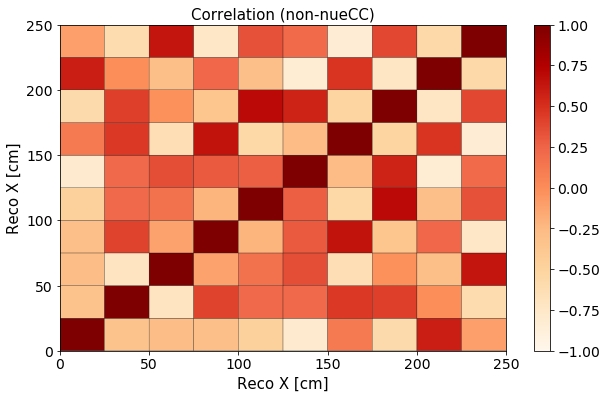

In [79]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, non_nueCC_detsys_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Correlation (non-nueCC)', fontsize=15)

plt.show()

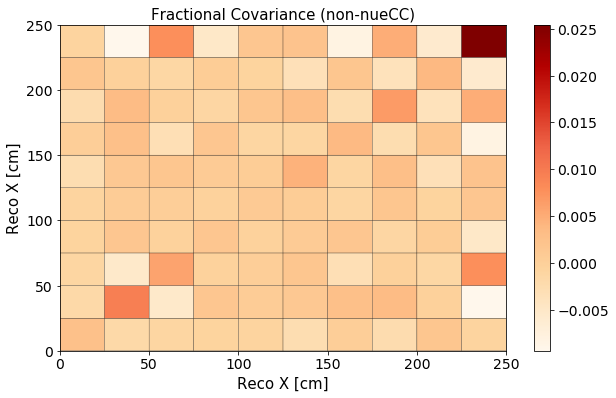

In [80]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, non_nueCC_detsys_dict['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Fractional Covariance (non-nueCC)', fontsize=15)

plt.show()

In [81]:
detvar_dict.keys()

dict_keys(['LYRayleigh', 'LYRayleigh_intrinsic', 'LYRayleigh_dirt', 'LYDown', 'LYDown_intrinsic', 'LYDown_dirt', 'SCE', 'SCE_intrinsic', 'SCE_dirt', 'Recomb2', 'Recomb2_intrinsic', 'Recomb2_dirt', 'WireModX', 'WireModX_intrinsic', 'WireModX_dirt', 'WireModYZ', 'WireModYZ_intrinsic', 'WireModYZ_dirt', 'WireModThetaXZ', 'WireModThetaXZ_intrinsic', 'WireModThetaXZ_dirt', 'WireModThetaYZ_withSigmaSplines', 'WireModThetaYZ_withSigmaSplines_intrinsic', 'WireModThetaYZ_withSigmaSplines_dirt', 'CV', 'CV_intrinsic', 'CV_dirt', 'cv_total_bkgd'])

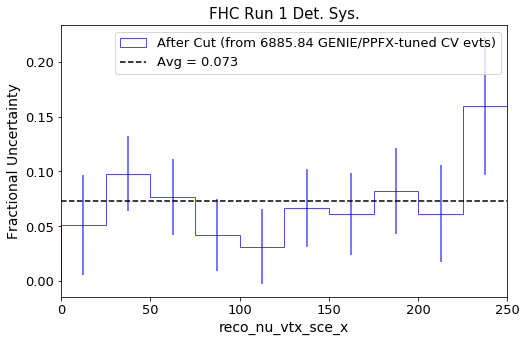

In [82]:


cv_cut = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune'])[0]
plt.close()

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]

plt.figure(figsize=(8, 5))

plt.errorbar(bin_centers, non_nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
             yerr=cv_cut_err, 
             color='blue', alpha=0.7)

plt.hist(bin_centers, bins, weights=non_nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
         label='After Cut (from '+str(round(sum(cv_cut),2))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

plt.hlines(np.average(non_nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
           label='Avg = '+str(round(np.average(non_nueCC_detsys_dict['fractional_uncertainty']), 3)))

plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(xvar, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 Det. Sys.", fontsize=15)
#plt.savefig(parameters(ISRUN3)['plots_path']+"RHCRUN3DetSys.pdf", transparent=True, bbox_inches='tight') 

plt.show()

In [83]:
evolution_dict['standard_bdtcut'] = non_nueCC_detsys_dict['fractional_uncertainty']
evolution_dict['standard_bdtcut_evts'] = round(sum(cv_cut),2)
evolution_dict['standard_bdtcut_err'] = cv_cut_err

Evolution

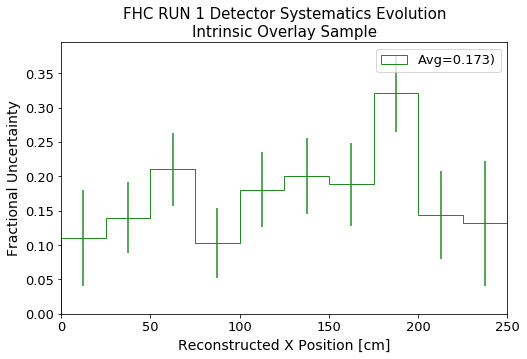

In [84]:
plt.figure(figsize=(8, 5))


# bdt cut
plt.hist(bin_centers, bins, weights=evolution_dict['nueCC_bdtcut'], histtype='step', color='forestgreen', 
        label='Avg='+str(round(np.average(evolution_dict['nueCC_bdtcut']),3))+')')
plt.errorbar(bin_centers, evolution_dict['nueCC_bdtcut'], fmt='none', yerr=evolution_dict['nueCC_bdtcut_err'], color='forestgreen')


plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.3)

plt.legend(fontsize=13)

plt.xlabel("Reconstructed X Position [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC RUN 1 Detector Systematics Evolution\nIntrinsic Overlay Sample", fontsize=15)

plt.show()

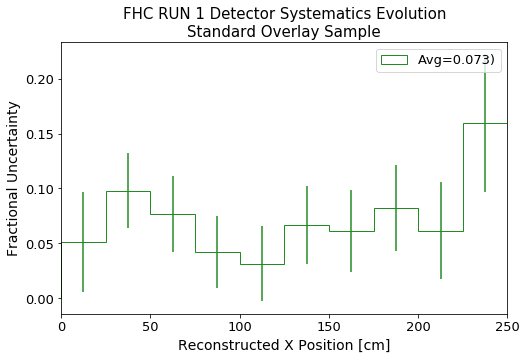

In [86]:
plt.figure(figsize=(8, 5))


# bdt cut
plt.hist(bin_centers, bins, weights=evolution_dict['standard_bdtcut'], histtype='step', color='forestgreen', 
        label='Avg='+str(round(np.average(evolution_dict['standard_bdtcut']),3))+')')
plt.errorbar(bin_centers, evolution_dict['standard_bdtcut'], fmt='none', yerr=evolution_dict['standard_bdtcut_err'], color='forestgreen')


plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 3.4)

plt.legend(fontsize=13)

plt.xlabel("Reconstructed X Position [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC RUN 1 Detector Systematics Evolution\nStandard Overlay Sample", fontsize=15)


plt.show()